
> ⚠️ **Warning:** This notebook file is paired to a .py file with the same name, such that we can cleanly import the functionality from other notebooks. This is done using the facilities of the jupytext package. The cells in this notebook that are only meant as "demonstration" are marked with the cell tag "active-ipynb", which causes the jupytext synchronization command to ignore these when syncing to the .py file. This is our current way of doing "literate programming" with jupyter notebooks.

## Proximal Policy Optimization (PPO)

In [ ]:
from single.mdp import SingleScheduleEnv, HorizonObservationWrapper, HorizonRollingWrapper
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from util import TqdmCallback
import os

log_dir = "logs/"
os.makedirs(log_dir, exist_ok=True)

class PpoRl:
    def __init__(self, steps=100, verbose=1):
        self.steps = steps
        self.verbose = verbose

    def make_wrapped_env(self, gen):
        env = SingleScheduleEnv(instance_generator=gen)
        env = HorizonObservationWrapper(env, max_vehicles_per_route=self.max_k)
        env = HorizonRollingWrapper(env)
        return env

    def train(self, gen):
        self.gen = gen
        # just inspect a sample to determine model feature "size"
        s = gen()
        self.R = len(s['release'])
        self.max_k = max(len(n) for n in s['release'])

        vec_env = make_vec_env(lambda: self.make_wrapped_env(gen), n_envs=4)
        # vec_env = VecMonitor(vec_env, filename="./logs/vec_monitor.csv")
        self.model = PPO("MultiInputPolicy", vec_env,
                         device='cpu', verbose=self.verbose) \
                            .learn(total_timesteps=self.steps,
                                   callback=TqdmCallback(self.steps))

    def eval(self, gen):
        env = self.make_wrapped_env(gen)
        env = Monitor(env)

        # Evaluate the policy
        mean_reward, std_reward = evaluate_policy(
            self.model, env,
            n_eval_episodes=100,     # number of episodes to test
            render=False,            # set True to see rendering
            deterministic=True,      # remove exploration noise
            return_episode_rewards=False
        )

        print(f"Mean reward: {mean_reward} +/- {std_reward}")
        return -mean_reward

## Demo

> ⚠️ **Warning:** Remember to tag these cells as `active-ipynb`.

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
from single.basics import generate_instance, uniform
from single.mdp import draw_horizon_obs

model = PpoRl(steps=2000, verbose=1)
gen = lambda: generate_instance(uniform(), n=[10, 10])
model.train(gen)
score = model.eval(gen)

Using cpu device


Training: 100%|██████████| 2000/2000 [00:00<00:00, 2687.27step/s]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | -181     |
| time/              |          |
|    fps             | 10453    |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 8192     |
---------------------------------


Training: 100%|██████████| 2000/2000 [00:02<00:00, 775.63step/s] 


Mean reward: -155.47679676 +/- 11.064987106602896


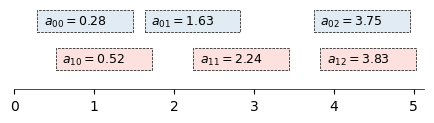

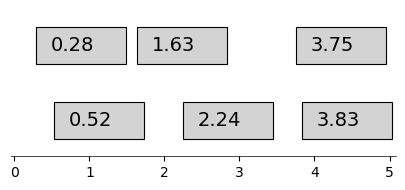

In [6]:
gen = lambda: generate_instance(uniform(), R=2, n=3)
env = SingleScheduleEnv(instance_generator=gen)
env = HorizonObservationWrapper(env)
env = HorizonRollingWrapper(env)
obs, _ = env.reset()
env.render()
draw_horizon_obs(obs)

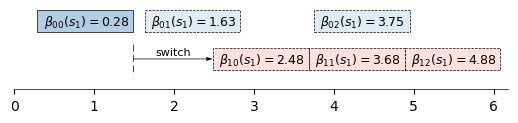

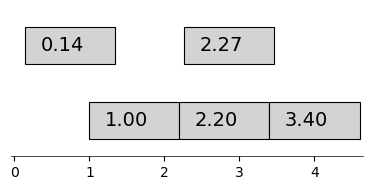

In [7]:
obs, *_ = env.step(0)
env.render()
draw_horizon_obs(obs)